# Cognition Academy 2025

Léopold Maytié

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ruflab/shimmer-tutorials/blob/main/Cognition_Academy/tutorial.ipynb)


In this notebook, we will see how to use a model inspired by the Global Workspace Theory

In [1]:
import torch

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU is available: {gpu_name}")
else:
    from IPython.display import HTML
    message = """
    <div style="color: red; font-weight: bold; font-size: 16px;">
        GPU is NOT enabled.<br>
        Please go to <b>Runtime > Change runtime type > Hardware accelerator > GPU</b> and select "GPU".
    </div>
    """
    display(HTML(message))

GPU is available: Tesla T4


In [2]:
%pip install tensorboard

In [3]:
%pip install ipywidgets
%pip install ipympl

In [4]:
!pip install "git+https://github.com/ruflab/shimmer-ssd.git"

  Cloning https://github.com/ruflab/shimmer-ssd.git to /tmp/pip-req-build-yv1ag4cb
  Running command git clone --filter=blob:none --quiet https://github.com/ruflab/shimmer-ssd.git /tmp/pip-req-build-yv1ag4cb
  Resolved https://github.com/ruflab/shimmer-ssd.git to commit 18e0e5de809eb640638cff1b19f29861c103fc3c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/ruflab/attributes-to-language.git (to revision v0.4.0) to /tmp/pip-install-9w0o1f8n/attributes-to-language_9493af4ff53f416eb2fd09916259346c
  Running command git clone --filter=blob:none --quiet https://github.com/ruflab/attributes-to-language.git /tmp/pip-install-9w0o1f8n/attributes-to-language_9493af4ff53f416eb2fd09916259346c
  Running command git checkout -q c3d3c6823a1a8d968a71f786a2384a8b14c3be77
  Resolved https://github.com/ruflab/attributes-to-language.git to commit c3d3c6823a1a8d968a71f786a2384a8b14c3be77
  In

In [5]:
from google.colab import output
output.enable_custom_widget_manager()

In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [7]:
from collections.abc import Mapping, Sequence
from pathlib import Path
from typing import Any, cast

import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from lightning.pytorch import Callback, Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from shimmer import DomainModule, LossOutput
from shimmer.modules.domain import DomainModule
from shimmer.modules.global_workspace import GlobalWorkspaceFusion, SchedulerArgs
from shimmer.modules.vae import (
    VAE,
    VAEDecoder,
    VAEEncoder,
    gaussian_nll,
    kl_divergence_loss,
)
from shimmer_ssd import DEBUG_MODE, LOGGER, PROJECT_DIR
from shimmer_ssd.config import DomainModuleVariant, LoadedDomainConfig, load_config
from shimmer_ssd.dataset.pre_process import TokenizeCaptions
from shimmer_ssd.logging import (
    LogAttributesCallback,
    LogGWImagesCallback,
    LogVisualCallback,
    batch_to_device,
)
from shimmer_ssd.modules.domains import load_pretrained_domains
from shimmer_ssd.modules.domains.visual import VisualLatentDomainModule
from shimmer_ssd.modules.vae import RAEDecoder, RAEEncoder
from tokenizers.implementations.byte_level_bpe import ByteLevelBPETokenizer
from torch import nn
from torch.nn.functional import mse_loss
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.optimizer import Optimizer
from torchvision.utils import make_grid

from simple_shapes_dataset import SimpleShapesDataModule, get_default_domains

# Dataset

The dataset we will use is called the Simple Shapes Dataset. It consists of colored shapes described in 3 different modalities.

* **Attributes**: A vector of attributes giving perfect description of the shape:

| Attributes    | Description                                               |
|---------------|-----------------------------------------------------------|
| cls           | type of shape: triangle, egg, diamond                     |
| x             | position of the shape on the x axis                       |
| y             | position of the shape on the y axis                       |
| size          | size of the shape                                         |
| rotation      | angle of the shape in radians (0 is pointing to the top)  |
| color         | RGB color of the shape                                    |


* **Vision**: A 32x32 RGB image of the shape on a black background
* **Text**: A caption in english describing the shape

<img src="https://lmaytie.com/tutorial/dataset_examples.png?" width="500"/>

Let download the dataset directly with:

In [8]:
!shapesd download --ckpturl "https://lmaytie.com/tutorial/simple_shapes_100k.tar.gz" --name "simple_shapes_100k"

2025-07-24 10:46:51.195193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753354011.229564    4695 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753354011.240124    4695 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
  0% 0.00/358M [00:00<?, ?B/s]
  0% 8.19k/358M [00:00<1:42:59, 57.9kB/s]
  0% 41.0k/358M [00:00<37:28, 159kB/s]   
  0% 106k/358M [00:00<20:07, 296kB/s] 
  0% 213k/358M [00:00<12:34, 474kB/s]
  0% 442k/358M [00:00<06:44, 883kB/s]
  0% 901k/358M [00:00<03:32, 1.68MB/s]
  1% 1.82M/358M [00:00<01:50, 3.23MB/s]
  1% 3.67M/358M [00:01<00:55, 6.34MB/s]
  1% 4.83M/358M [00:01<00:51, 6.82MB/s]
  2% 7.72M/358M [00:01<00:32, 10.9MB/s]
  3% 10.

The different modalities composing the dataset can be aligned (paired) or not. For example a generated text can describe an image or be unrelated to any as shown here:

<img src="https://lmaytie.com/tutorial/paired.png?" width="500"/>

We need to define how many samples in the dataset are aligned across all modalities. In this case, we are using fully paired data (each sample includes an image, its corresponding attributes, and a descriptive text).

However, it's also possible to train with only a subset of fully paired samples, while the rest of the dataset includes unpaired data from individual modalities (e.g., many images, texts, and attribute sets without direct links). This setup enables leveraging large amounts of unimodal data while still learning cross-modal relationships, thanks to cycle-consistency losses, which we will discuss later.

In [9]:
!shapesd alignment add --dataset_path "simple_shapes_100k" --seed 0 --domain_alignment attr,t,v 1.0

2025-07-24 10:48:14.081532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753354094.101708    5081 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753354094.107772    5081 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Training a Global Workspace

Now that we have a dataset let go through the Global Workspace model used in this tutorial


The code used in this tutorial is split across three repositories, each with a specific role:

1. **[simple-shapes-dataset](https://github.com/ruflab/simple-shapes-dataset)**  
   Implements the *Simple Shapes* dataset described earlier.  
   * This is the **data source** used in our experiments.

2. **[shimmer](https://github.com/ruflab/shimmer)**  
   Implements the **core Global Workspace architecture**, designed to be modular and reusable across multiple datasets.  
   * This is the **framework** that defines the common components of the model.

3. **[shimmer-ssd](https://github.com/ruflab/shimmer-ssd)**  
   Specializes the Global Workspace model for the *Simple Shapes* dataset by integrating it with `simple-shapes-dataset` and extending the base functionality from `shimmer`.  
   * This is the **task-specific implementation** built on top of the other two.


The Global Workspace is defined as a pytorch lightning module named **GlobalWorkspace**. It is composed of different elements:
* Pre-trained unimodal models to encode raw high dimensional data into unimodal latent vectors. These models are defined as **DomainModule**
* Encoders and Decoders as well as losses and coefficients to train them. All of these are defined inside **GWModule**

<img src="https://lmaytie.com/tutorial/shimmer_architecture.png" width="1500"/>

GlobalWorkspace Classes
* DomainModule: Unimodal model for each modality
* GWModule: Encoders and Decoders composing the Global Workspace model

## Unimodal Domains

Let first go through the **DomainModules**. Their role is to encode raw data into latent vectors. As we have three different modalities here we are going to define one module for each modality.

No training is required here, as we will load pre-trained models to focus on learning within the Global Workspace.

**DomainModule** requires a set of function common to all modalities to work:
* `def encode(self, x: Any) -> torch.Tensor`: encodes raw data into unimodal latent representation
* `def decode(self, z: torch.Tensor) -> Any`: decoded unimodal latent representation into raw data
* `def compute_loss(self, pred: torch.Tensor, target: torch.Tensor, raw_target: Any) -> LossOutput | None`: The loss used for this domain by the Global Workspace to compute cycle consitency or translation. `pred` is the predicted unimodal latent vector coming from the Global Workspace, `target` is the target latent vector and `raw_target` is the original input before being encoded.

In addition classical fucntions of Pytorch Lightning must be implemented: `configure_optimizers`, `training_step`, and `validation_step`. See the [lightning docs](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) for more details.

### Vision

The visual domain module is based on a Variational Autoencoder (VAE) architecture. It encodes an input image into a unimodal latent vector using the reparameterization trick during training. This trick allows the model to sample from a Gaussian distribution in a way that is compatible with gradient-based optimization, making the latent space more suitable for generating new images.

At inference time, the model skips sampling and simply uses the mean of the predicted distribution as the latent representation.

The decoder then takes this latent vector and attempts to reconstruct the original image.

The model is trained with two objectives:
* Latent regularization: Encourage the latent space to follow a standard Gaussian distribution using a Kullback–Leibler (KL) divergence loss between the predicted distribution (mean and variance) and a standard normal distribution.
* Reconstruction: Ensure that the decoder can accurately reconstruct the input image by minimizing a reconstruction loss (e.g., mean squared error or binary cross-entropy) between the predicted image and the ground truth.

<img src="https://lmaytie.com/tutorial/Uni_V.png" width="1000"/>

In this project, the vision module is implemented in the class called `VisualDomainModule`.

Once the VAE is trained, it becomes computationally expensive to run the encoder (a large CNN) on every image during the training of the Global Workspace. To avoid this overhead, we use a simple but effective trick:
we precompute and save the visual latent vectors for all images in the dataset as .npy files. This allows us to bypass the encoder during Global Workspace training and significantly speed up the process.

To support this setup, we define a second class called `VisualLatentDomainModule`. This class takes precomputed visual latent vectors as input and adapts the `encode()` and `decode()` methods accordingly. In other words, instead of computing latents from raw images, it directly works with the stored latent representations.

### Attributes

The attributes module is very similar to the visual module. It is also implemented as a VAE, but instead of processing images, it takes attribute vectors as input. It is defined as `AttributesDomainModule`

Aside from the input format, the architecture and training process remain the same:
the encoder maps the attribute vector to a latent distribution, and the decoder reconstructs the original vector from a sampled latent code. The model is trained using both reconstruction loss and KL divergence, just like in the visual case.

<img src="https://lmaytie.com/tutorial/Uni_Attr.png?v=1234" width="1000"/>

### Text

The text module, implemented as `GRUTextDomainModule`, is a bit more complex than the visual and attributes modules. It consists of three main components:

**Encoder**:
* **Tokenizer and Embedding Layer**: Converts raw natural language text into token vectors.
* **BERT Encoder**: Processes the token sequence and extracts the [CLS] token, which serves as a fixed-size representation summarizing the sentence.
* **VAE Encoder**: Projects the high-dimensional [CLS] embedding into a lower-dimensional latent space using a variational encoder.

**Decoder**:
* **VAE Decoder**: Reconstructs the [CLS] token embedding from the latent vector.
* **GRU Decoder**: Generates the original sentence autoregressively from the reconstructed latent representation.

**Training Objectives**:
* **VAE Losses**: Encourage the latent space to follow a Gaussian distribution using KL divergence and reconstruction of the [CLS] embedding.
* **Sentence Reconstruction Loss**: Trains the GRU decoder to regenerate the original sentence as closely as possible from the latent vector.

<img src="https://lmaytie.com/tutorial/Uni_text.png" width="1000"/>

## Global Workspace

### Theory

#### Global Workspace Core Architecture

The Global Workspace model integrates multiple pre-trained unimodal models and a set of encoders decoders to form a unified representation. Let's illustrate how data go through the model taking the Figure bellow as an example.

We start from raw observations:
- Visual input: $o^v$
- Textual input: $o^t$

Each of these is passed through a **pretrained unimodal encoder**:
- A VAE (for vision)
- A BERT-Encoder model (for text)

These produce **unimodal latent representations**:
- $u^v$ from visual input
- $u^t$ from textual input

Each unimodal latent vector is then encoded into a **pre-fusion Global Workspace vector**:
- $z^v = e_v(u^v)$
- $z^t = e_t(u^t)$  
where $e_v$ and $e_t$ are modality-specific MLP encoders.

The two pre-fusion vectors are then fused into a single **Global Workspace representation** $z$ using a weighted sum:

$$
z = \alpha_v \cdot z^v + \alpha_t \cdot z^t
$$

Here, $\alpha_v$ and $\alpha_t$ are modality-specific attention weights that determine how much each modality contributes to the final shared representation.

Finally, this shared representation is decoded back into unimodal latent spaces:
- $\hat{u}^v$ for the vision modality
- $\hat{u}^t$ for the text modality

<p align="center">
  <img src="https://lmaytie.com/tutorial/GW_fusion_t_v.png" width="1000"/>
</p>


#### Loss Functions

The model is trained using multiple loss functions, each encouraging a different type of **cross-modal interaction**. These are shown in the figure below:

##### 1. Contrastive Loss ($\mathcal{L}_{\text{cont}}$)

- Applied between pre-fusion vectors ($z^v$, $z^t$)
- Encourages **alignment** of representations before fusion
- Logged as: `contrastive_A_and_B`


##### 2. Broadcast Loss ($\mathcal{L}_{\text{borad}}$)

Encourages **cross-modal decoding** through the Global Workspace. This consists of several sub-losses:

- **Translation Loss** ($\mathcal{L}_{\text{tr}}$):  
  Translate from one modality to another via the workspace  
  → Requires **paired data**  
  → Logged as: `From A to B`

- **Demi-Cycle Loss** ($\mathcal{L}_{\text{dcy}}$):  
  Encode and decode within the **same modality** through the workspace  
  → Can use **unpaired data**  
  → Logged as: `From A to A`

- **Cycle Loss** ($\mathcal{L}_{\text{cy}}$):  
  Translate to another modality, then back to the original  
  → Can use **unpaired data**  
  → Logged as: `From A through B to A` or `From A through {B,C} to A`

- **Fusion Loss** ($\mathcal{L}_{\text{fusion}}$):  
  Fuse multiple modalities before decoding  
  → Requires **paired data**  
  → Logged as:  
    - `From {A,B,C} to A`  
    - `From {A,B} to C`  
    - `From {A,B} to {A,B,C}`

<p align="center">
  <img src="https://lmaytie.com/tutorial/losses.png?" width="1000"/>
</p>


### Practice

Let's first generate the `config` folder, which will contain the YAML files used by the other scripts and this notebook

In [10]:
!ssd config create

2025-07-24 10:48:24.858192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753354104.878916    5139 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753354104.884978    5139 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We have to update `main.yaml` file. It has to be done manually by oppening the file and copy pasting the content bellow

First, let's use the dataset we downloaded earlier
```yaml
dataset:
    path: "./simple_shapes_100k" # Path to the simple-shapes-dataset
```

let's reduce the batch size to be able to run it on google colab
```yaml
training:
    batch_size: 128
    max_steps: 5000
```

let's update the alignment split to get the same we defined at the beginning:
```yaml
domain_proportions:
    -   domains: ["v", "t", "attr"]  # vision, attributes and text paired passes uses 100% of the available data
        proportion: 1.0
```

let's change the selected domains and their checkpoint:

```yaml
domains:
    - checkpoint_path: "./checkpoints/domain_v.ckpt"    # visual module checkpoint
      domain_type: v_latents
    - checkpoint_path: "./checkpoints/domain_attr.ckpt" # attributes module checkpoint
      domain_type: attr
    - checkpoint_path: "./checkpoints/domain_t.ckpt"    # text module checkpoint
      domain_type: t
```

and let's define the global workspace dimenison to 16 and the coefficient of each loss:
```yaml
global_workspace:
    latent_dim: 16  
    
    loss_coefficients:
        cycles: 1.0
        contrastives: 0.1
        demi_cycles: 1.0
        translations: 1.0

    encoders:
        hidden_dim: 32
        n_layers: 3

    decoders:
        hidden_dim: 32
        n_layers: 3
```

A lot of files are genrated by this command. For this tutorial we are going to use two of them: `main.yaml` and `train_gw.yaml`

<div class="alert alert-info">
Anytime you make a change to the config, don't forget to reload it with the following cell!
</div>

In [21]:
config = load_config("./config", use_cli=False, load_files=["train_gw.yaml"])

This tutorial also require the simple-shapes dataset tokenizer data, so let's download this from the `shimmer-ssd` repository:

In [12]:
!ssd download tokenizer

2025-07-24 10:48:35.910614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753354115.930324    5193 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753354115.936233    5193 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
  0% 0.00/1.84k [00:00<?, ?B/s]
1it [00:00, 4084.04it/s]
3.97kB [00:00, 7.84MB/s]       
  0% 0.00/3.69k [00:00<?, ?B/s]
2it [00:00, 7115.02it/s]
8.91kB [00:00, 17.2MB/s]       


Let's skip the training of these unimodal modules and download checkpoints from pre-trained models

In [13]:
# Download checkpoints
!ssd download checkpoints --ckpturl "https://lmaytie.com/tutorial/tutorial_simple_shapes_models_ckpt.tar.gz"

# Extract visual latent from pretrained visual domain
!ssd extract v "checkpoints/domain_v.ckpt" -p "simple_shapes_100k"

2025-07-24 10:48:47.216693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753354127.236626    5249 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753354127.242761    5249 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
  0% 0.00/53.5M [00:00<?, ?B/s]
  0% 8.19k/53.5M [00:00<15:50, 56.3kB/s]
  0% 41.0k/53.5M [00:00<05:44, 155kB/s] 
  0% 106k/53.5M [00:00<03:05, 288kB/s] 
  0% 213k/53.5M [00:00<01:55, 462kB/s]
  1% 442k/53.5M [00:00<01:01, 860kB/s]
  2% 901k/53.5M [00:00<00:32, 1.63MB/s]
  3% 1.82M/53.5M [00:01<00:16, 3.15MB/s]
  7% 3.67M/53.5M [00:01<00:08, 6.17MB/s]
 11% 5.64M/53.5M [00:01<00:05, 8.35MB/s]
 17% 8.91M/53.5M [00:01<00:03, 12.6MB/s]
 

We can now load pretrained unimodal modules

In [22]:
domain_modules, gw_encoders, gw_decoders = load_pretrained_domains(
    config.domains,
    config.global_workspace.latent_dim,
    config.global_workspace.encoders.hidden_dim,
    config.global_workspace.encoders.n_layers,
    config.global_workspace.decoders.hidden_dim,
    config.global_workspace.decoders.n_layers,
)

And instanciate the Global Workspace class

In [23]:
def get_scheduler(optimizer: Optimizer) -> OneCycleLR:
    return OneCycleLR(optimizer, config.training.optim.max_lr, config.training.max_steps)


global_workspace = GlobalWorkspaceFusion(
    domain_modules,
    gw_encoders,
    gw_decoders,
    config.global_workspace.latent_dim,
    config.global_workspace.loss_coefficients,
    config.training.optim.lr,
    config.training.optim.weight_decay,
    scheduler=get_scheduler,
)

As we are working with pytorch Lightning we need to define a **DataModule**. It will handle the different Datasets and DataLoaders for us. For more details about **DataModule** please refer to [lightning docs](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.core.LightningDataModule.html#lightning.pytorch.core.LightningDataModule)

In [24]:
domain_classes = get_default_domains(["v_latents", "attr", "t"])

additional_transforms = {}
additional_transforms["t"] = [
    TokenizeCaptions(
        config.domain_modules.text.vocab_path,
        config.domain_modules.text.merges_path,
        config.domain_modules.text.seq_length,
    )
]

data_module = SimpleShapesDataModule(
        config.dataset.path,
        domain_classes,
        config.domain_proportions,
        batch_size=config.training.batch_size,
        num_workers=config.training.num_workers,
        seed=config.seed,
        ood_seed=config.ood_seed,
        domain_args=config.domain_data_args,
        additional_transforms=additional_transforms,
    )

We are going to use tensorboard to follow the training

In [ ]:
logger = TensorBoardLogger("logs", name="gw")

# Get some image samples to log in tensorboard.
train_samples = data_module.get_samples("train", 32)
val_samples = data_module.get_samples("val", 32)

# split the unique group in validation into individual groups for logging
for domains in val_samples:
    for domain in domains:
        val_samples[frozenset([domain])] = {domain: val_samples[domains][domain]}
    break
# Create attr folder where we will save checkpoints
(config.default_root_dir / "gw").mkdir(exist_ok=True)

callbacks: list[Callback] = [
        LogGWImagesCallback(
            val_samples,
            log_key="images/val",
            mode="val",
            every_n_epochs=config.logging.log_val_medias_every_n_epochs,
            filter=config.logging.filter_images,
            vocab=config.domain_modules.text.vocab_path,
            merges=config.domain_modules.text.merges_path,
        ),
        LogGWImagesCallback(
            train_samples,
            log_key="images/train",
            mode="train",
            every_n_epochs=config.logging.log_train_medias_every_n_epochs,
            filter=config.logging.filter_images,
            vocab=config.domain_modules.text.vocab_path,
            merges=config.domain_modules.text.merges_path,
        ),
        # Save the checkpoints
        ModelCheckpoint(
            dirpath=config.default_root_dir / "gw" / f"version_{logger.version}",
            filename="{epoch}",
            monitor="val/loss",
            mode="min",
            save_last="link",
            save_top_k=1,
        ),
    ]

For the final model, let's save where the model is saved:

In [ ]:
gw_checkpoint = config.default_root_dir / "gw" / f"version_{logger.version}"
print(gw_checkpoint)

Load tensorboard. You can select the version associated to the previous path. It will appear after the training is started.

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir "./logs/gw" --reload_interval 30 --reload_task 'auto'

Let's train!

In [ ]:
trainer = Trainer(
    logger=logger,
    max_steps=config.training.max_steps,
    default_root_dir=config.default_root_dir,
    callbacks=callbacks,
    precision=config.training.precision,
    accelerator=config.training.accelerator,
    devices=config.training.devices,
)

trainer.fit(global_workspace, data_module)
trainer.validate(global_workspace, data_module, "best")

# Playing with the Global Workspace

The training of a Global Workspace can be long, especially with 3 modalities. So let's use a pre-trained checkpoint to play a bit with the model.

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline

The Global Workspace model we are going to use is a bit bigger than the one we started to train. It still relies on the same unimodal modules.

So let's redefine the config parameters to fit with our model

We have to update `main.yaml` file

```yaml
global_workspace:
    latent_dim: 32  
    
    loss_coefficients:
        cycles: 1.0
        contrastives: 0.1
        demi_cycles: 1.0
        translations: 1.0

    encoders:
        hidden_dim: 64
        n_layers: 2

    decoders:
        hidden_dim:
            v_latents: 128
            t: 64
            attr: 64
        n_layers: 2
```

In [26]:
config = load_config("./config", use_cli=False, load_files=["train_gw.yaml"])

We can now load pretrained unimodal modules and the defined Global Workspace encoders and decoders

In [27]:
domain_modules, gw_encoders, gw_decoders = load_pretrained_domains(
    config.domains,
    config.global_workspace.latent_dim,
    config.global_workspace.encoders.hidden_dim,
    config.global_workspace.encoders.n_layers,
    config.global_workspace.decoders.hidden_dim,
    config.global_workspace.decoders.n_layers,
)

Now let's load the Global Workspace from the checkpoint

In [28]:
checkpoint_path = Path("./checkpoints")
checkpoint = checkpoint_path / "gw_dd835ybh.ckpt" # "gw_3_all.ckpt"

global_workspace = GlobalWorkspaceFusion.load_from_checkpoint(
    checkpoint,
    domain_mods=domain_modules,
    gw_encoders=gw_encoders,
    gw_decoders=gw_decoders,
)
global_workspace.to(device)

GlobalWorkspaceFusion(
  (gw_mod): GWModule(
    (domain_mods): ModuleDict(
      (v_latents): VisualLatentDomainModule(
        (visual_module): VisualDomainModule(
          (vae): VAE(
            (encoder): RAEEncoder(
              (layers): Sequential(
                (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU()
                (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (5): ReLU()
                (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (8): ReLU()
                (9): Conv2d(128, 256, kernel_size=(4, 4)

In [29]:
domain_classes = get_default_domains(["v_latents", "attr", "t"])

additional_transforms = {}
additional_transforms["t"] = [
    TokenizeCaptions(
        config.domain_modules.text.vocab_path,
        config.domain_modules.text.merges_path,
        config.domain_modules.text.seq_length,
    )
]

data_module = SimpleShapesDataModule(
        config.dataset.path,
        domain_classes,
        config.domain_proportions,
        batch_size=config.training.batch_size,
        num_workers=config.training.num_workers,
        seed=config.seed,
        ood_seed=config.ood_seed,
        domain_args=config.domain_data_args,
        additional_transforms=additional_transforms,
    )

And take some data from the dataset to play with

In [30]:
train_samples = data_module.get_samples("train", 32)
train_samples = batch_to_device(train_samples, device)
print(train_samples.keys())

dict_keys([frozenset({'attr', 't', 'v_latents'})])


This group contains three modalities: vision, attributes and text all paired together

In [31]:
paired_samples = train_samples[frozenset(["v_latents", "t", "attr"])]

### Images

Let's first look at the selected images

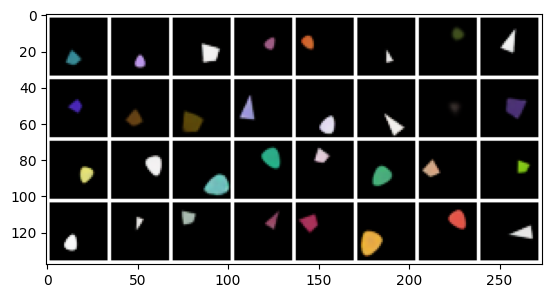

In [32]:
img_uni = paired_samples['v_latents']
img = domain_modules['v_latents'].decode_images(img_uni)
grid = make_grid(img, nrow=8, pad_value=1)
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

### Attributes

Now let’s look at the selected attributes. As you can see, the raw attribute vectors are not easy to interpret directly.

To make them more understandable, we will visualize the corresponding generated image whenever we refer to attributes in the rest of this tutorial. This makes it easier to grasp what the attribute representation actually means.

In [33]:
from simple_shapes_dataset.pre_process import tensor_to_attribute, UnnormalizeAttributes
import pandas as pd

In [34]:
unormalize = UnnormalizeAttributes()
attr_uni = paired_samples['attr']
attr = tensor_to_attribute(attr_uni)
attr = unormalize(attr)

data = {field: getattr(attr, field).tolist() for field in attr._fields[:-1]}
df = pd.DataFrame(data)
display(df)

,category,x,y,size,rotation,color_r,color_g,color_b
0,0,13.0,10.0,9.0,0.128725,59.999996,137.000000,148.000000
1,1,16.0,8.0,7.0,6.270611,185.000000,154.000000,232.000000
2,0,20.0,13.0,12.0,0.679484,255.000000,235.000000,240.000000
3,1,20.0,18.0,7.0,5.743750,161.000000,85.000000,131.000000
4,1,7.0,18.0,8.0,3.678406,200.000000,100.000000,49.999996
5,2,17.0,11.0,7.0,0.273828,244.000000,218.000000,214.000000
6,0,22.0,23.0,8.0,4.701317,65.000000,91.000000,46.999996
7,2,17.0,20.0,13.0,5.915638,237.000000,239.000000,238.000000
8,0,14.0,17.0,8.0,1.633971,74.000000,46.999996,179.000000
9,0,13.0,11.0,10.0,6.169944,102.000000,71.000000,23.999998


### Text

Finally, let’s take a look at the textual data. The sentences are stored as lists of tokens, but don’t worry, it’s easy to convert them back into natural language.
We simply use the same tokenizer, but in reverse, to decode the tokens back into readable text.

In [35]:
tokenizer = ByteLevelBPETokenizer(
    config.domain_modules.text.vocab_path,
    config.domain_modules.text.merges_path,
)

def get_text_samples(samples: dict[str, torch.Tensor]) -> list[str]:
    """
    Decode the token sequence into a full sentence.
    """
    return tokenizer.decode_batch(
        samples["tokens"].detach().cpu().tolist(),
        skip_special_tokens=True,
    )

In [36]:
train_text_samples = get_text_samples(paired_samples["t"])
for k, text in enumerate(train_text_samples, 1):
    print(k, text.replace("<pad>", ""))


1 There is a little steel blue colored deformed square shape, at the lower side, slightly left, pointing north.
2 It is a plum tiny oval shaped structure, at the bottom, pointing to the northeast.
3 The image is a lavender blush medium sized arrow-shaped polygon, pointing towards the top-left, located slightly lower side, at the right.
4 There is a tiny grey colored egg, pointing to the north-northeast, at the center right.
5 A kind of tiny shape pointing to the south-southeast, it is located slightly upper side, at the very left side, it is in chocolate color, and looks like an oval shaped structure.
6 The image contains a tiny antique white isosceles triangle, pointing north-northwest, at the bottom center.
7 This is a dark olive green diamond, it is pointing towards the right, it is at the very upper side, at the right, it is tiny.
8 The image contains a big white smoke isosceles triangle. It is located top. It is pointing to the north-northeast.
9 The image represents a rebecca pur

## Translations

Now that we are familiar with the data, let's use the global workspace to do some translations.

### Translation vision to text

Let's begin with vision to text translation. This task can be called image captioning.

In [37]:
import matplotlib.gridspec as gridspec
import textwrap

We first encode the raw data into the unimodal latent representations with encode_domain:

In [38]:
latent_img_uni = global_workspace.encode_domain(paired_samples["v_latents"], "v_latents")

Then, we encode the unimodal visual representation into the GW reprensentation. First we encode the reprensentations

In [39]:
gw_latent_v = global_workspace.gw_mod.encode({"v_latents": latent_img_uni})

Then we fuse the latents together. As we have only one input (the latent images), we put all the weights on the visual modality

In [40]:
gw_latent_v_fused = global_workspace.gw_mod.fuse(gw_latent_v, {"v_latents": torch.ones(gw_latent_v['v_latents'].size(0)).to(device)})

Finally, we decode the Global Workspace representation:

In [41]:
decoded_latent_uni = global_workspace.gw_mod.decode(gw_latent_v_fused)

Now let's visualize what we obtained.

The Figure represent each generated caption with the ground truth image bellow

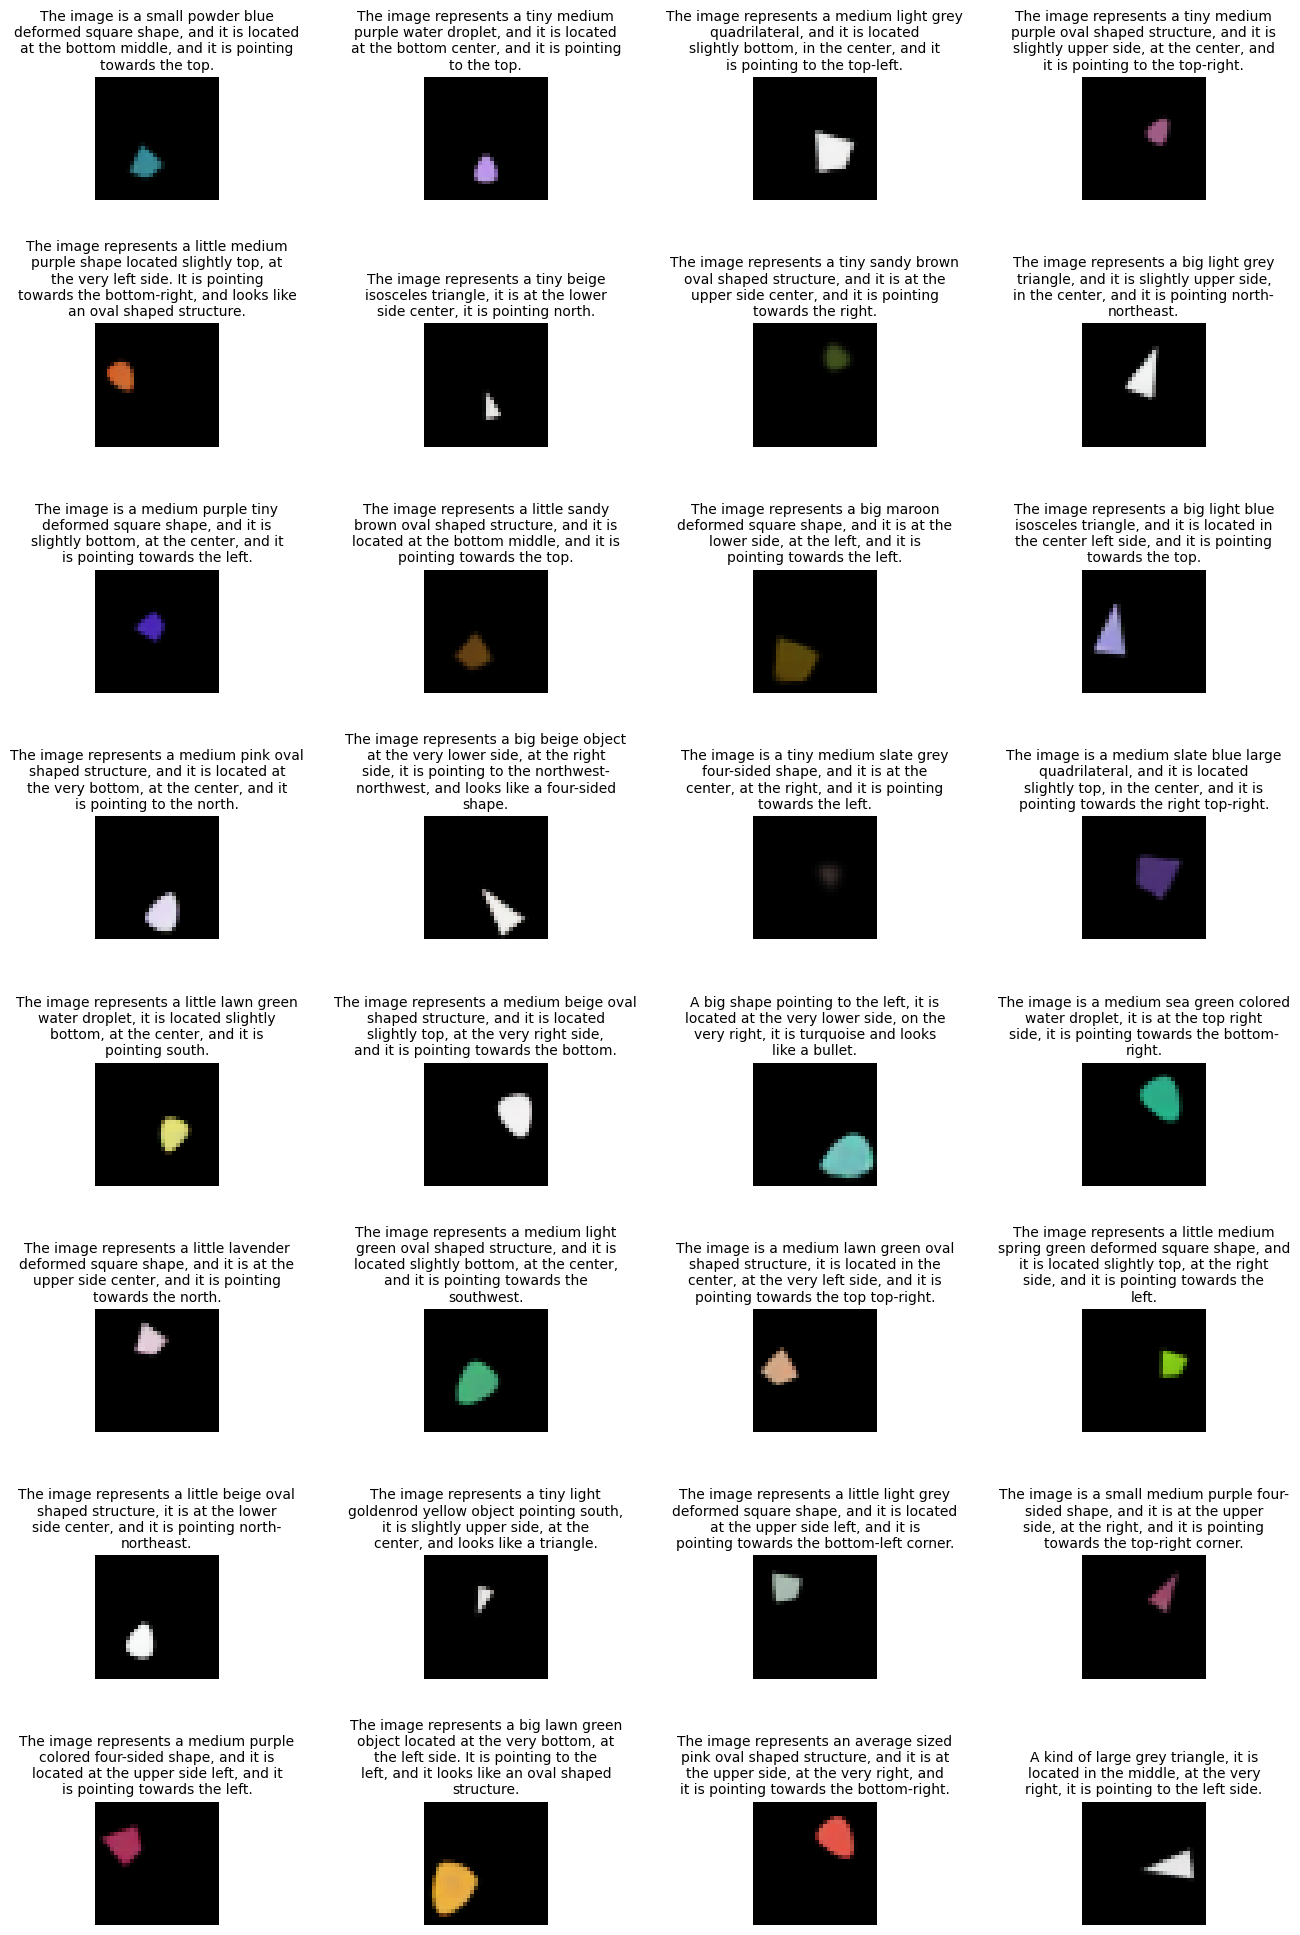

In [42]:
decoded_texts = global_workspace.decode_domain(decoded_latent_uni["t"], "t")
reconstructed_text = get_text_samples(decoded_texts)

cols = 4
rows = 8
fig = plt.figure(figsize=(16, 24))
gs = gridspec.GridSpec(rows, cols, wspace=0.3, hspace=1.0)

for i in range(32):
    ax = fig.add_subplot(gs[i])
    ax.imshow(img[i].permute(1, 2, 0).detach().cpu().numpy())
    wrapped_caption = "\n".join(textwrap.wrap(reconstructed_text[i].replace("<pad>", ""), width=40))
    ax.set_title(wrapped_caption, fontsize=10)
    ax.axis('off')

plt.show()

### Translation text to vision

We can try the other way aroung, translating text into images.

We follow the same process as before.

First we encode the text into unimodal latent representation

In [43]:
latent_txt_uni = global_workspace.encode_domain(paired_samples["t"], "t")

Then we encode the unimoal representation inside the Global Workspace

In [44]:
gw_latent_t = global_workspace.gw_mod.encode({"t": latent_txt_uni})

Before fusing the representations. As we only have text encoded this time we put all the weights on the text modality

In [45]:
gw_latent_t_fused = global_workspace.gw_mod.fuse(gw_latent_t, {"t": torch.ones(gw_latent_t['t'].size(0)).to(device)})

And we finally decode it from the Global Workspace to unimodal representations

In [46]:
decoded_latent_uni = global_workspace.gw_mod.decode(gw_latent_t_fused)

Now let's visualize what we obtained.

The Figure represent each ground truth caption with the predicted image bellow

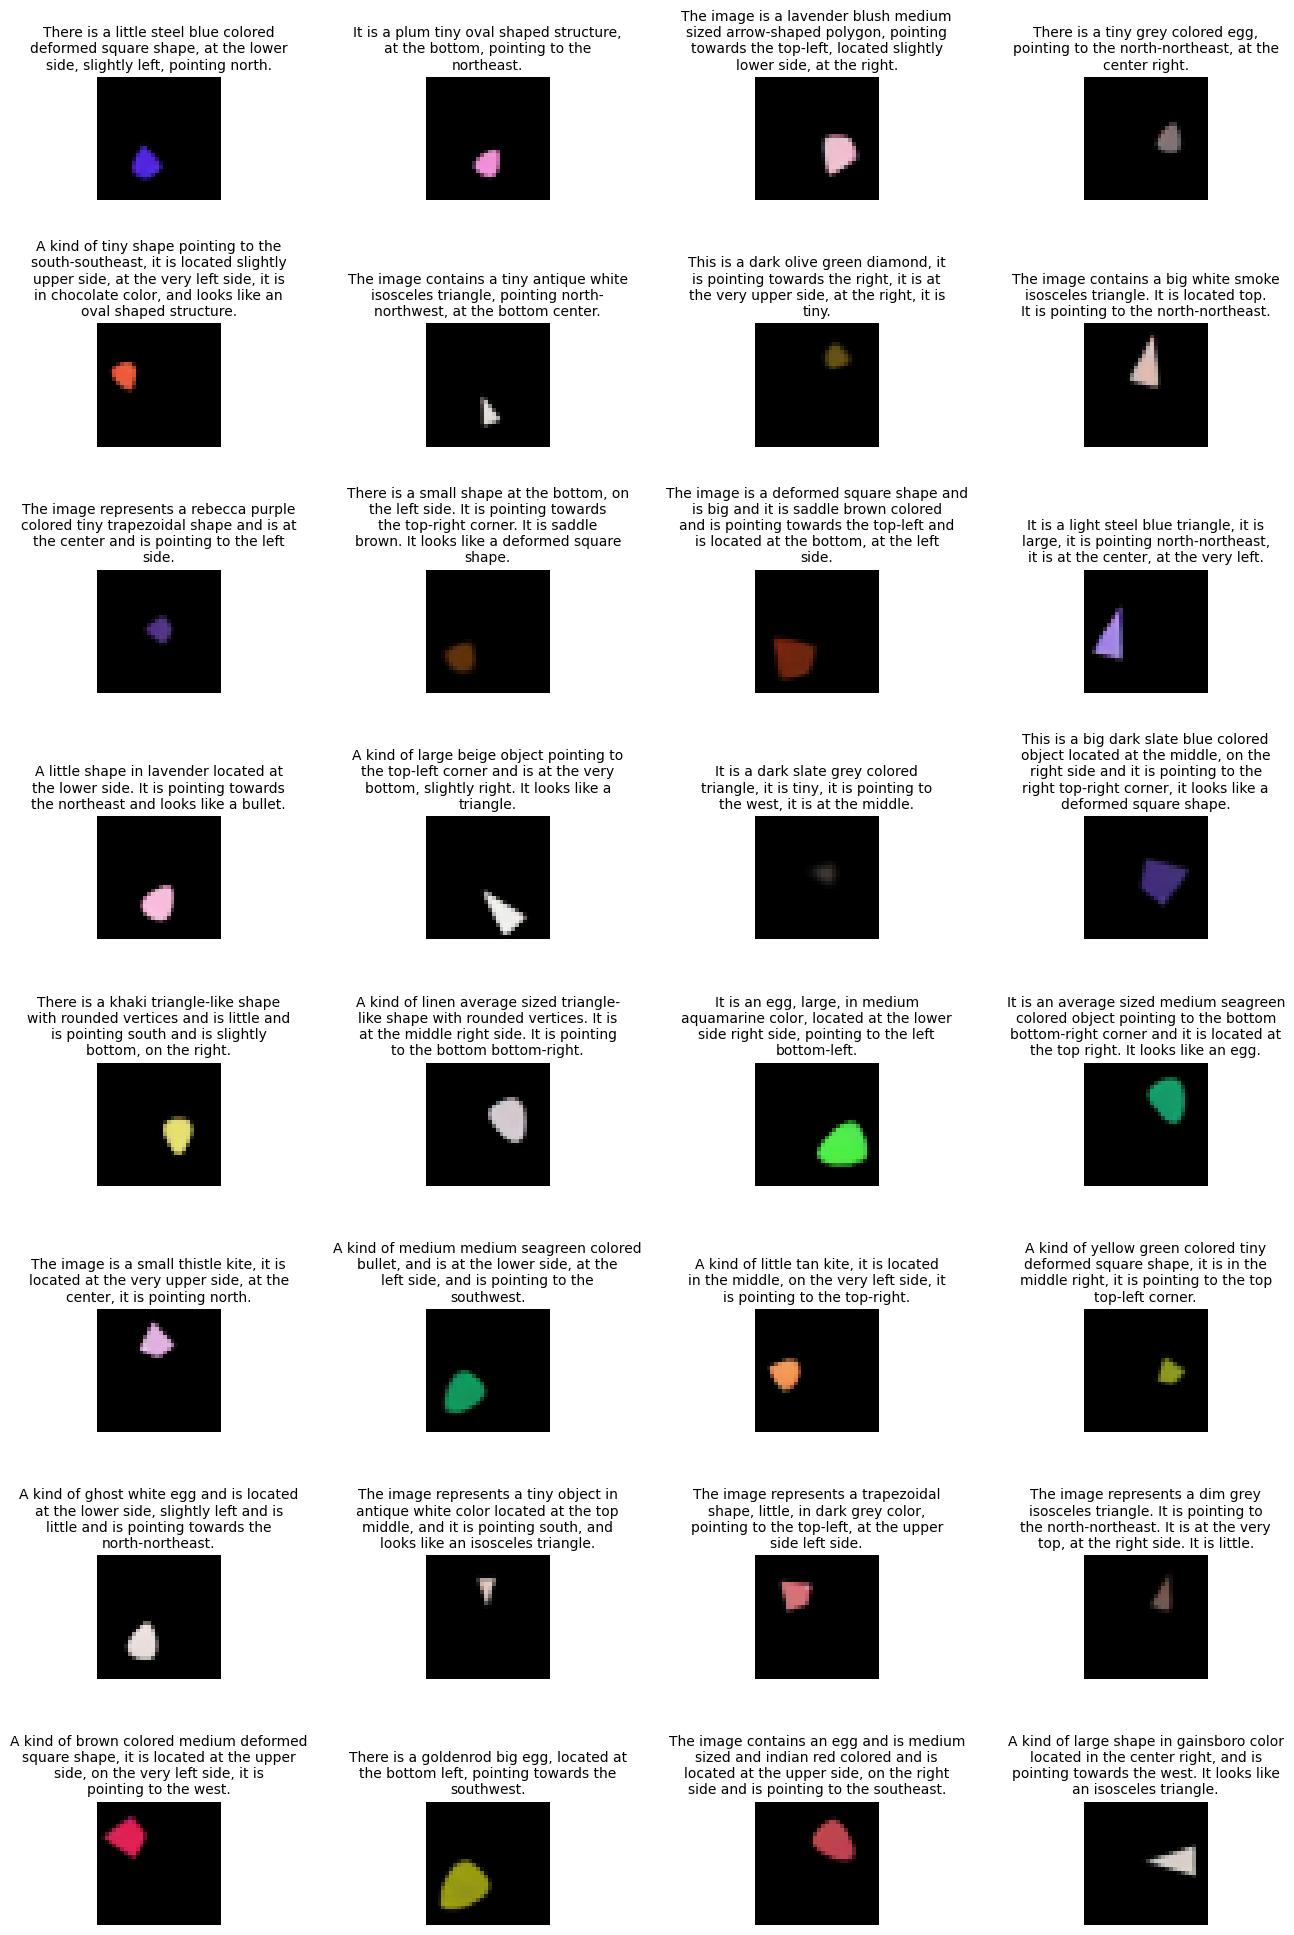

In [47]:
decoded_images = domain_modules['v_latents'].decode_images(decoded_latent_uni['v_latents'])
text_input = get_text_samples(paired_samples["t"])

cols = 4
rows = 8
fig = plt.figure(figsize=(16, 24))
gs = gridspec.GridSpec(rows, cols, wspace=0.3, hspace=1.0)

for i in range(32):
    ax = fig.add_subplot(gs[i])
    ax.imshow(decoded_images[i].permute(1, 2, 0).detach().cpu().numpy())
    wrapped_caption = "\n".join(textwrap.wrap(train_text_samples[i].replace("<pad>", ""), width=40))
    ax.set_title(wrapped_caption, fontsize=10)
    ax.axis('off')

plt.show()

### Translation attributes to any

In [48]:
latent_attr_uni = global_workspace.encode_domain(paired_samples["attr"], "attr")
gw_latent_attr = global_workspace.gw_mod.encode({"attr": latent_attr_uni})
gw_latent_attr_fused = global_workspace.gw_mod.fuse(gw_latent_attr, {"attr": torch.ones(gw_latent_attr['attr'].size(0)).to(device)})
decoded_latent_uni = global_workspace.gw_mod.decode(gw_latent_attr_fused)

## Fusion Mechanism

Now that we’re familiar with translation, let’s explore the impact of the fusion mechanism in more detail.

In this section, we’ll generate two different inputs that vary along one or more dimensions (shape class, location, size, rotation, or color) across two different modalities (e.g., vision and attributes).
These two inputs will then be fused inside the Global Workspace, using a gradient of attention weights that shifts gradually from giving full attention to the first modality to giving full attention to the second.

To better understand how the model handles conflicting or complementary information, we’ll visualize this process by displaying a sequence of images, each corresponding to a different attention coefficient. This allows us to observe how the Global Workspace integrates multimodal inputs under varying fusion conditions.

In [49]:
import numpy as np
import torchvision
from PIL import Image
from torchvision.utils import save_image

from simple_shapes_dataset.domain import Attribute
from simple_shapes_dataset.cli.utils import generate_image, generate_class, generate_scale, generate_location, generate_rotation, generate_color
from simple_shapes_dataset.pre_process import attribute_to_tensor, tensor_to_attribute, NormalizeAttributes, UnnormalizeAttributes

Let's first generate the two different data we are going to pass to the Global Workspace.

In this case we are going to fuse attributes and vision data.
For this we generate random attributes that will serve either as attributes modality or to generate an image.

In [50]:
n_samples = 1
min_scale = 7
max_scale = 14
imsize = 32
min_lightness = 0
max_lightness = 256
dpi = 1

classes = generate_class(n_samples)
sizes = generate_scale(n_samples, min_scale, max_scale)
locations = generate_location(n_samples, max_scale, imsize)
rotation = generate_rotation(n_samples)
colors_rgb, colors_hls = generate_color(n_samples, min_lightness, max_lightness)

Now let's specify which attributes we want to change between vision and attributes. In this case we are going to change the size and color of the shape.

In [51]:
colors_rgb_v = np.array([[243, 57, 82]])
sizes_v  = np.array([7.])

colors_rgb_attr = np.array([[57, 88, 243]])
sizes_attr = np.array([14.])

Let's display the input image for the Global Workspace

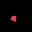

In [52]:
fig, ax = plt.subplots(figsize=(imsize / dpi, imsize / dpi), dpi=dpi)
ax = cast(plt.Axes, ax)
generate_image(ax, classes[0], locations[0], sizes_v[0], rotation[0], colors_rgb_v[0], imsize)
ax.set_facecolor("black")
plt.tight_layout(pad=0)
plt.savefig('gt_v.png', dpi=dpi, format="png")

Let's display the image associated to the input attributes for the Global Workspace

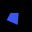

In [53]:
fig, ax = plt.subplots(figsize=(imsize / dpi, imsize / dpi), dpi=dpi)
ax = cast(plt.Axes, ax)
generate_image(ax, classes[0], locations[0], sizes_attr[0], rotation[0], colors_rgb_attr[0], imsize)
ax.set_facecolor("black")
plt.tight_layout(pad=0)
plt.show()

Now let's encode the raw modalities into unimodal latent vectors and get the expected data format for the Global Workspace.

In [54]:
path = 'gt_v.png'
with Image.open(path) as image:
    img = image.convert("RGB")

tensor_img = torchvision.transforms.functional.pil_to_tensor(img).to(global_workspace.device).to(dtype=torch.float32) / 255.


norm_attr = NormalizeAttributes()
unorm_attr = UnnormalizeAttributes()

attr = torch.FloatTensor(np.concatenate([classes, locations[0], sizes_attr, rotation, colors_rgb_attr[0]])).to(device)

attr = Attribute(
    category = attr[0].to(torch.long),
    x = attr[1],
    y = attr[2],
    size = attr[3],
    rotation = attr[4],
    color_r = attr[5] / 255,
    color_g = attr[6] / 255,
    color_b = attr[7] / 255,
    unpaired = None
)

attr = norm_attr(attr)
attr_tensor = attribute_to_tensor(attr)

uni_attr = domain_modules['attr'].encode(attr_tensor)
uni_attr = uni_attr.unsqueeze(0)

pred_attr = domain_modules['attr'].decode(uni_attr)
pred_attr = tensor_to_attribute(pred_attr)
pred_attr = unorm_attr(pred_attr)

uni_v = domain_modules['v_latents'].visual_module.vae.encoder(tensor_img[None,:])[0]

data = {frozenset({'v_latents', 'attr'}): {'v_latents': uni_v, 'attr': uni_attr}}

We are going to fuse the image and attributes with weights between 0 (all attention on image) to 1 (all attention on attributes)

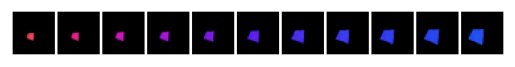

In [55]:
images = []
for attention in np.linspace(0,1,11):
    selection = {"attr": torch.ones(1).to(device) * attention, "v_latents": torch.ones(1).to(device) * (1 - attention)}
    gw_latent = global_workspace.gw_mod.encode(data[frozenset({'v_latents', 'attr'})])
    gw_latent_fused = global_workspace.gw_mod.fuse(gw_latent, selection)

    pred_attr_uni = global_workspace.gw_mod.decode(gw_latent_fused)['attr']
    pred_v_uni = global_workspace.gw_mod.decode(gw_latent_fused)

    decoded = global_workspace.gw_mod.decode(gw_latent_fused)

    attr_pred = decoded["attr"]
    v_pred = decoded["v_latents"]

    new_img = domain_modules['v_latents'].decode_images(v_pred)
    images.append(new_img[0])

grid = make_grid(images, nrow=11, pad_value=1)
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()

## Play by yourself

In [56]:
%pip install ipywidgets
%pip install ipympl

In [57]:
import io
import math

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interact_manual
from PIL import Image
from shimmer_ssd.logging import attribute_image_grid
from torch.nn.functional import one_hot
from torchvision.transforms.functional import to_tensor

from simple_shapes_dataset.cli import generate_image
%matplotlib widget

### Generate images and text from attributes

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_workspace.to(device)

cat2idx = {"Diamond": 0, "Egg": 1, "Triangle": 2}

def get_image(cat, x, y, size, rot, color_r, color_g, color_b):
    fig, ax = plt.subplots(figsize=(32, 32), dpi=1)
    # The dataset generatoion tool has function to generate a matplotlib shape
    # from the attributes.
    generate_image(
        ax,
        cat2idx[cat],
        [int(x * 18 + 7), int(y * 18 + 7)],
        size * 7 + 7,
        rot * 2 * math.pi,
        np.array([color_r * 255, color_g * 255, color_b * 255]),
        imsize=32,
    )
    ax.set_facecolor("black")
    plt.tight_layout(pad=0)
    # Return this as a PIL Image.
    # This is to have the same dpi as saved images
    # otherwise matplotlib will render this in very high quality
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    image = Image.open(buf)
    plt.close(fig)
    return image

In [59]:
tokenizer = ByteLevelBPETokenizer(
    config.domain_modules.text.vocab_path,
    config.domain_modules.text.merges_path,
)

def get_text_samples(samples: dict[str, torch.Tensor]) -> list[str]:
    """
    Decode the token sequence into a full sentence.
    """
    return tokenizer.decode_batch(
        samples["tokens"].detach().cpu().tolist(),
        skip_special_tokens=True,
    )

interactive(children=(Dropdown(description='cat', options=('Triangle', 'Egg', 'Diamond'), value='Triangle'), F…

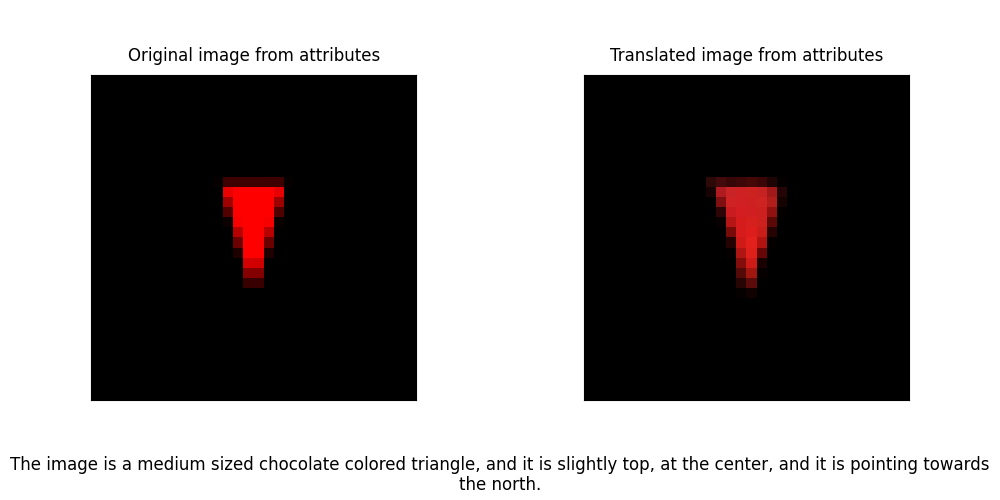

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_workspace.to(device)

cat2idx = {"Diamond": 0, "Egg": 1, "Triangle": 2}

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
img_axes = [axes[0], axes[1]]

titles = ["Original image from attributes", "Translated image from attributes"]
for ax, title in zip(img_axes, titles):
    ax.set_title(title, fontsize=12, pad=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor("black")

text_box = fig.text(0.5, 0.05, "", ha='center', va='center', fontsize=12, wrap=True)

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.2)

@interact(
    cat=["Triangle", "Egg", "Diamond"],
    x=(0, 1, 0.1),
    y=(0, 1, 0.1),
    rot=(0, 1, 0.1),
    size=(0, 1, 0.1),
    color_r=(0, 1, 0.1),
    color_g=(0, 1, 0.1),
    color_b=(0, 1, 0.1),
)
def update(
    cat: str = "Triangle",
    x: float = 0.5,
    y: float = 0.5,
    rot: float = 0.5,
    size: float = 0.5,
    color_r: float = 1,
    color_g: float = 0,
    color_b: float = 0,
):
    image = get_image(cat, x, y, size, rot, color_r, color_g, color_b)
    image_tensor = to_tensor(image)[:3].unsqueeze(0).to(device)
    image_latent = domain_modules['v_latents'].visual_module.encode(image_tensor)

    attr_gw_latent = global_workspace.gw_mod.encode({
        "v_latents": global_workspace.encode_domain(image_latent, "v_latents")
    })

    gw_latent = global_workspace.gw_mod.fuse(
        attr_gw_latent,
        {"v_latents": torch.ones(attr_gw_latent["v_latents"].size(0)).to(device)}
    )

    decoded_latents = global_workspace.gw_mod.decode(gw_latent)
    decoded_texts = global_workspace.decode_domain(decoded_latents["t"], "t")
    reconstructed_text = get_text_samples(decoded_texts)[0].replace("<pad>", "").strip()

    decoded_img_tensor = global_workspace.domain_mods["v_latents"].decode_images(decoded_latents["v_latents"])[0]
    decoded_img = decoded_img_tensor.permute(1, 2, 0).detach().cpu().numpy()

    for ax in img_axes:
        for im in ax.get_images():
            im.remove()

    img_axes[0].imshow(image)
    img_axes[1].imshow(decoded_img)

    text_box.set_text(reconstructed_text)

    fig.canvas.draw_idle()


#classification !!

In [61]:
data_module.setup("fit")

In [67]:
x = next(iter(data_module.train_dataloader()))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [68]:

    def extract_classification_targets_from_batch(
        batch,
        bins_per_axis=2,
        n_color_bins=2,
        n_dir_bins=4,
        scale_bins=None,
    ):
        """Extracts binned classification labels from fused batch with rich print diagnostics."""

        #print("🔍 Extracting classification targets from batch...")

        sample = batch[0]
        key = next(iter(sample))
        attr_raw = sample[key]["attr"]["raw_labels"]

        # === Shape ===
        shape_targets = attr_raw["shape"]
        #print(f"\n🎯 SHAPE: {shape_targets[:5].tolist()} (type={shape_targets.dtype}, shape={shape_targets.shape})")

        # === Position ===
        x, y = attr_raw["position"]
        #print("\n📍 POSITION:")
        #print(f"  x range: [{x.min().item():.2f}, {x.max().item():.2f}]")
        #print(f"  y range: [{y.min().item():.2f}, {y.max().item():.2f}]")
        #print(f"  Binning into {bins_per_axis} × {bins_per_axis} grid")

        grid_x = ((x + 1) * 0.5 * bins_per_axis).long().clamp(0, bins_per_axis - 1)
        grid_y = ((y + 1) * 0.5 * bins_per_axis).long().clamp(0, bins_per_axis - 1)
        position_targets = grid_y * bins_per_axis + grid_x

        for bx in range(bins_per_axis**2):
            count = (position_targets == bx).sum().item()
            #print(f"    Bin {bx:2d}: {count:3d} samples")

        # === Direction ===
        rotation = attr_raw["rotation"]
        #print("\n🔄 DIRECTION:")
        #print(f"  Raw rotation range: [{rotation.min().item():.2f}, {rotation.max().item():.2f}] radians")
        #print(f"  Objective: {n_dir_bins} bins")

        direction_targets = ((rotation / (2 * math.pi)) * n_dir_bins).long() % n_dir_bins

        for b in range(n_dir_bins):
            count = (direction_targets == b).sum().item()
            #print(f"    Bin {b}: {count} samples")

        # === Scale ===
        scale = attr_raw["scale"]
        #print("\n📏 SCALE:")
        #print(f"  Raw scale range: [{scale.min().item():.2f}, {scale.max().item():.2f}]")
        if scale_bins is None:
            thresholds = torch.linspace(-1.0, 1.0, steps=4, device=scale.device)[1:-1]
            #print(f"  Auto thresholds: {thresholds.tolist()}")
        else:
            thresholds = scale_bins.to(scale.device)
            #print(f"  Provided thresholds: {thresholds.tolist()}")

        scale_targets = torch.bucketize(scale, thresholds)

        for i in range(len(thresholds)+1):
            count = (scale_targets == i).sum().item()
            #print(f"    Bin {i}: {count} samples")

        # === Color ===
        r, g, b = attr_raw["color_rgb"]
        #print("\n🎨 COLOR:")
        #print(f"  Raw r range: [{r.min().item():.2f}, {r.max().item():.2f}]")
        #print(f"  Raw g range: [{g.min().item():.2f}, {g.max().item():.2f}]")
        #print(f"  Raw b range: [{b.min().item():.2f}, {b.max().item():.2f}]")

        r = (r + 1) * 0.5
        g = (g + 1) * 0.5
        b = (b + 1) * 0.5

        max_rgb, _ = torch.stack([r, g, b], dim=0).max(dim=0)
        min_rgb, _ = torch.stack([r, g, b], dim=0).min(dim=0)
        delta = max_rgb - min_rgb + 1e-5

        hue = torch.zeros_like(r)
        mask_r = (max_rgb == r)
        mask_g = (max_rgb == g)
        mask_b = (max_rgb == b)

        hue[mask_r] = ((g - b)[mask_r] / delta[mask_r]) % 6
        hue[mask_g] = ((b - r)[mask_g] / delta[mask_g]) + 2
        hue[mask_b] = ((r - g)[mask_b] / delta[mask_b]) + 4

        hue = (hue / 6.0) % 1.0
        color_targets = (hue * n_color_bins).long() % n_color_bins

        #print(f"  Hue range after conversion: [{hue.min().item():.2f}, {hue.max().item():.2f}]")
        for b in range(n_color_bins):
            count = (color_targets == b).sum().item()
            #print(f"    Bin {b}: {count} samples")


        # === Final structure
        return {
            "shape": shape_targets,
            "position": position_targets,
            "direction": direction_targets,
            "scale": scale_targets,
            "color": color_targets,
        }

In [70]:
print("x : ", x)

x :  ({frozenset({'attr', 't', 'v_latents'}): {'v_latents': tensor([[-0.0092, -0.6780, -0.3164,  ...,  0.0524,  0.1842, -0.0118],
        [ 0.5356, -0.5442, -1.1072,  ..., -0.6069, -0.0605, -1.2987],
        [-2.8163, -0.0198,  0.1831,  ...,  0.9094, -1.5584,  0.0898],
        ...,
        [ 0.1073, -0.0751, -1.2692,  ..., -0.3624, -1.3522,  0.3333],
        [ 1.2289,  0.1093,  0.9983,  ...,  0.0869, -1.0258,  0.0049],
        [-0.3069,  0.2310, -0.9582,  ..., -0.9323, -1.6326,  0.1230]]), 'attr': [tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
  

In [69]:
targets = extract_classification_targets_from_batch(x)

TypeError: list indices must be integers or slices, not str